# Convert stellar-surface flux to measured telescope flux

This notebook opens a PHOENIX FITS spectrum (assumed to contain surface flux), reads the stellar radius from the metadata/header, and converts the surface flux into the expected flux at Earth and the power collected by a telescope.

Specify the distance to the star (in parsec), telescope diameter (m), and primary mirror obstruction fraction (0..1).

Notes: verify the `BUNIT` in the FITS header to confirm units of the flux. The PHOENIX models use `erg / s / cm^2 / cm` in the example metadata; the notebook converts that to `W / m^2 / m` for plotting and power calculations.

In [10]:
# Imports and locate data directory (project-level `data/`)
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.units as u
from astropy.constants import c

# locate project data directory one level up from notebooks/
nb_dir = os.getcwd()
project_dir = os.path.dirname(nb_dir)
data_dir = os.path.join(project_dir, 'data')
print('project dir:', project_dir)
print('data dir:', data_dir)
files = glob(os.path.join(data_dir, '*.fits')) + glob(os.path.join(data_dir, '*.FITS'))
print('found', len(files), 'fits file(s)')
files[:10]

project dir: /home/mathis/Documents/s4
data dir: /home/mathis/Documents/s4/data
found 2 fits file(s)


['/home/mathis/Documents/s4/data/lte06000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits',
 '/home/mathis/Documents/s4/data/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits']

In [11]:
# Select a FITS file and read spectrum (flux + wavelength)
if len(files) == 0:
    raise FileNotFoundError('No FITS files found in data/ — put your FITS file into data/')

filename = files[0]  # change if you want a specific file
print('Using', filename)

with fits.open(filename) as hdul:
    # pick first 1D data extension as flux
    data_ext = None
    wave_ext = None
    for i, hdu in enumerate(hdul):
        if getattr(hdu, 'data', None) is None:
            continue
        if isinstance(hdu.data, np.ndarray) and hdu.data.ndim == 1 and data_ext is None:
            data_ext = i
        if hdu.name.upper() == 'WAVE':
            wave_ext = i
    print('data_ext=', data_ext, 'wave_ext=', wave_ext)
    flux = hdul[data_ext].data.astype(float)
    header = hdul[data_ext].header

    # wavelength: try WAVE extension or CRVAL/CDELT keywords
    if wave_ext is not None:
        wavelength = hdul[wave_ext].data.astype(float)
    else:
        if 'CRVAL1' in header and 'CDELT1' in header and 'NAXIS1' in header:
            crval = header['CRVAL1']
            cdelt = header['CDELT1']
            naxis1 = header['NAXIS1']
            wavelength = crval + cdelt * np.arange(naxis1)
        else:
            wavelength = np.arange(flux.size)

# convert arrays to numpy arrays
wavelength = np.array(wavelength)
flux = np.array(flux)
print('loaded flux length', flux.size, 'wavelength length', wavelength.size)

Using /home/mathis/Documents/s4/data/lte06000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
data_ext= 0 wave_ext= None
loaded flux length 1569128 wavelength length 1569128


In [12]:
# Parameters you can edit
distance_pc = 10.0  # distance to star in parsec (edit)
tel_diameter_m = 0.508  # telescope diameter in meters (edit)
primary_obstruction = 0.39  # fraction of area blocked (0..1) (edit)

# Get stellar radius from header if available (PHXREFF often in cm in PHOENIX metadata)
r_star = None
if 'PHXREFF' in header:
    try:
        # PHXREFF in example metadata is in [cm]
        r_star = header['PHXREFF'] * u.cm
        print('Found PHXREFF in header:', header['PHXREFF'], 'cm')
    except Exception as e:
        print('PHXREFF present but could not parse:', e)

if r_star is None:
    raise KeyError('Stellar radius not found in header (PHXREFF) — please add it or pick another file')

# Convert to meters and compute distance
r_star_m = r_star.to(u.m)
distance = (distance_pc * u.pc).to(u.m)
print(f'R_star = {r_star_m:.3e}, distance = {distance:.3e}')

Found PHXREFF in header: 131120000000.0 cm
R_star = 1.311e+09 m, distance = 3.086e+17 m


In [13]:
# Units: assume FITS BUNIT is erg / s / cm^2 / cm (surface flux per wavelength unit in cm).
# Build astropy unit accordingly and convert to W / (m^2 * m)
try:
    bunit = header.get('BUNIT', '').strip()
    print('BUNIT header:', bunit)
except Exception:
    bunit = ''

# PHOENIX example: 'erg/s/cm^2/cm' -> define unit as erg / (s cm2 cm)
surface_unit = u.erg / (u.s * u.cm**2 * u.cm)
# assign unit to flux array (surface flux)
flux_surface = (flux * surface_unit)
# convert surface flux to SI: W / (m^2 * m)
flux_surface_si = flux_surface.to(u.W / (u.m**2 * u.m))

# geometric dilution: flux at Earth = surface_flux * (R_star / distance)**2
dilution = (r_star_m / distance)**2
flux_earth_si = flux_surface_si * dilution

# telescope collecting area (effective)
area_tel = np.pi * (tel_diameter_m / 2.0)**2 * (1.0 - primary_obstruction) * u.m**2
# power collected per unit wavelength (W / m) = flux_earth_si * area_tel
power_collected_per_m = flux_earth_si * area_tel  # units: W / m
# Optionally convert power per meter to power per Angstrom for plotting: 1 A = 1e-10 m
power_collected_per_A = power_collected_per_m.to(u.W / u.m) * (1.0 * u.m / (1e10 * u.Angstrom))

print('dilution factor (R/d)^2 =', dilution)
print('effective telescope area =', area_tel)

BUNIT header: erg/s/cm^2/cm
dilution factor (R/d)^2 = 1.805663381308542e-17
effective telescope area = 0.12363662489978945 m2


In [19]:
# Rescale input spectrum to a requested apparent magnitude
# star_magnitude: input magnitude in the AB system (assumption — change if you use Vega).
# This rescales the flux at Earth so the average flux between 600-650 nm matches the AB magnitude.

# Edit this number to the desired apparent magnitude (AB):
star_magnitude = 1.0  # AB mag (change as needed)

# Band limits (nm) used to compute the average scaling
band_min_nm = 600.0
band_max_nm = 650.0

# Heuristic to construct wavelength Quantity used elsewhere (match plotting heuristic)
try:
    w_q = w if isinstance(w, u.Quantity) else (wavelength * u.Unit('cm') if wavelength.max() > 1.0 and wavelength.max() < 1e6 else wavelength * u.m)
except Exception:
    # fallback if previous variables not defined
    w_q = wavelength * u.m

w_nm = w_q.to(u.nm).value
mask = (w_nm >= band_min_nm) & (w_nm <= band_max_nm)
if not np.any(mask):
    print(f'No wavelength points found between {band_min_nm} and {band_max_nm} nm — cannot rescale by magnitude')
else:
    # Compute AB f_nu in physical units using astropy
    # AB zero point: m_AB = -2.5 log10(f_nu[erg/s/cm2/Hz]) - 48.60
    m = float(star_magnitude)
    f_nu_cgs = 10 ** (-(m + 48.6) / 2.5) * u.erg / (u.s * u.cm**2 * u.Hz)
    f_nu_si = f_nu_cgs.to(u.W / (u.m**2 * u.Hz))

    # Convert constant f_nu to f_lambda at each wavelength: f_lambda = f_nu * c / lambda^2
    lam = (w_q.to(u.m))
    f_lambda = (f_nu_si * c) / (lam ** 2)
    # Ensure units are W / (m^2 * m)
    f_lambda = f_lambda.to(u.W / (u.m**2 * u.m))

    # Target average over the band
    target_avg = np.mean(f_lambda[mask].value)

    # Current average of flux at Earth (flux_earth_si is W / (m^2 * m))
    current_avg = np.mean(flux_earth_si[mask].value)

    if current_avg <= 0 or not np.isfinite(current_avg):
        print('Current spectrum has non-positive or non-finite average in band — cannot rescale')
    else:
        scale = target_avg / current_avg
        # apply scaling to flux_earth_si and recompute collected power
        flux_earth_si = flux_earth_si * scale
        power_collected_per_m = flux_earth_si * area_tel
        power_collected_per_A = power_collected_per_m.to(u.W / u.m) * (1.0 * u.m / (1e10 * u.Angstrom))
        print(f'Star magnitude set to AB {star_magnitude:.2f}: applied scale factor {scale:.3e}')
        print(f'New band average (W m^-2 m^-1): target={target_avg:.3e}, current(before)={current_avg:.3e}, after={np.mean(flux_earth_si[mask].value):.3e}')

# Note: This modifies `flux_earth_si`, `power_collected_per_m`, and `power_collected_per_A` in-place.
# Re-run downstream cells (photon count cell) to update detected counts with the new scaling.


No wavelength points found between 600.0 and 650.0 nm — cannot rescale by magnitude


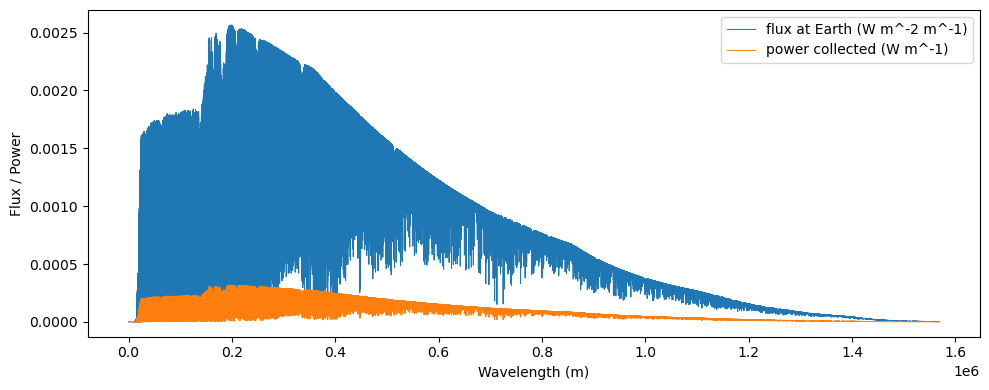

In [20]:
# Plotting: show surface flux (converted) and flux at Earth and collected power (linear axes)
plt.figure(figsize=(10,4))
# convert wavelength to meters for axis if wavelength originally in cm (PHOENIX examples often have wavelength in cm)
# Attempt to infer wavelength unit from header or scale: if values are >>1 (e.g. 1e-7) treat as meters; if ~1e4 treat as Angstrom etc.
w = wavelength * u.Unit('cm') if wavelength.max() > 1.0 and wavelength.max() < 1e6 else wavelength * u.m
w_m = w.to(u.m).value

# sanitize values: replace inf/nan with small or zero values appropriate for linear plotting
flux_surface_plot = np.nan_to_num(flux_surface_si.value, nan=0.0, posinf=np.finfo(float).max, neginf=0.0)
flux_earth_plot = np.nan_to_num(flux_earth_si.value, nan=0.0, posinf=np.finfo(float).max, neginf=0.0)
power_collected_plot = np.nan_to_num(power_collected_per_m.value, nan=0.0, posinf=np.finfo(float).max, neginf=0.0)

#plt.plot(w_m, flux_surface_plot, label='surface flux (W m^-2 m^-1)', lw=0.7)
plt.plot(w_m, flux_earth_plot, label='flux at Earth (W m^-2 m^-1)', lw=0.7)
plt.plot(w_m, power_collected_plot, label='power collected (W m^-1)', lw=0.7)
plt.xlabel('Wavelength (m)')
plt.ylabel('Flux / Power')
plt.legend()
plt.tight_layout()
plt.show()

Notes and next steps:
- Verify the FITS `BUNIT` for the correct input units. If your spectrum uses Angstrom or nanometer bins, adjust the `surface_unit` accordingly.
- Add instrument throughput, detector quantum efficiency, and exposure time to compute expected counts.
- If you want photon rates instead of power, divide power by photon energy `E = h*c / lambda`.
- I can add an interactive UI to set the parameters if you want (`ipywidgets`).

Exposure: 60.0 s, throughput=0.3, QE=0.7
Total detected photons (counts): 4.7403069133925063e+33


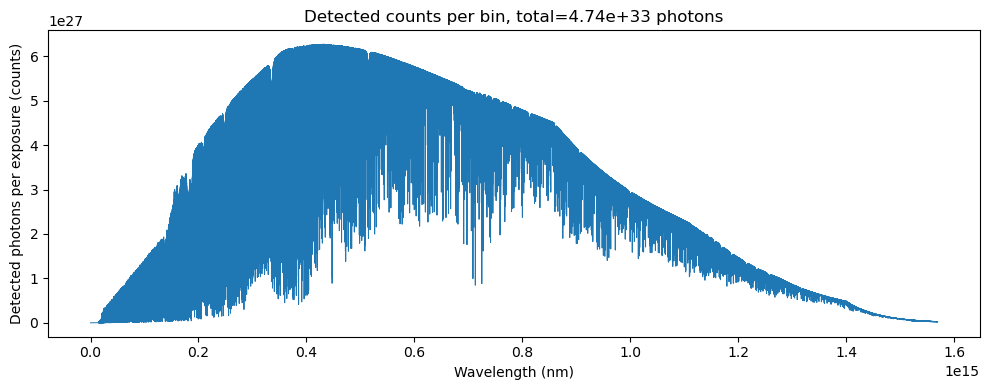

In [16]:
# Convert collected power to photon counts (new cell)
from astropy.constants import h

# Parameters (edit as needed)
exposure_s = 60.0            # exposure time in seconds
instrument_throughput = 0.3  # total optical throughput (0..1)
detector_qe = 0.7            # detector quantum efficiency (0..1)

# ensure wavelength array has units
w_q = w.to(u.m) if not isinstance(w, u.Quantity) else w
# power_collected_per_m is expected as Quantity (W / m)
power_q = power_collected_per_m.to(u.W / u.m)

# compute bin widths (delta lambda) in meters
delta_lambda = np.gradient(w_q.to(u.m).value) * u.m

# photons per second in each spectral bin: (power_per_m * delta_lambda * lambda) / (h*c)
photons_per_s_per_bin = (power_q * delta_lambda * w_q) / (h * c)
# sanitize negative/nan values
photons_per_s_per_bin = np.nan_to_num(photons_per_s_per_bin.value, nan=0.0, neginf=0.0, posinf=np.finfo(float).max) * (1.0 / u.s)
photons_per_s_per_bin = photons_per_s_per_bin.to(1.0 / u.s)

# detected photons (counts) for the exposure time including throughput and QE
detected_photons_per_bin = photons_per_s_per_bin * exposure_s * instrument_throughput * detector_qe

# total detected counts
total_counts = np.sum(detected_photons_per_bin.value)
print(f'Exposure: {exposure_s} s, throughput={instrument_throughput}, QE={detector_qe}')
print('Total detected photons (counts):', total_counts)

# Plot detected counts per bin vs wavelength
plt.figure(figsize=(10,4))
plt.plot(w_q.to(u.nm).value, detected_photons_per_bin.value, lw=0.7)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Detected photons per exposure (counts)')
plt.title(f'Detected counts per bin, total={total_counts:.3g} photons')
plt.tight_layout()
plt.show()

# Expose results for later use
counts_per_bin = detected_photons_per_bin
photons_per_s = photons_per_s_per_bin


Found 3 lamp spectrum files in /home/mathis/Documents/s4/data/lamp_spectra
Target wavelength grid: 0.0 - 1569126999999999.8 nm, 1569128 bins
Read HPS_High_Pressure_Sodium_2176K_Riba_Roja_cor.txt: 601 rows, range 300.0-900.0 nm
Read LED_streetlamp_2973K_75deg_of_axis_LICA_Philips_cor.txt: 601 rows, range 300.0-900.0 nm
Read LED_streetlamp_3107K_on_axis_LICA_Philips_cor.txt: 601 rows, range 300.0-900.0 nm
Background: background_level=1000.0 ph/s/nm (shape normalized); total detected counts per exposure=0


/tmp/ipykernel_6657/2648537167.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(p, comment='#', delim_whitespace=True, header=None, names=['wavelength_nm','flux_rel'], encoding='utf-8')
/tmp/ipykernel_6657/2648537167.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(p, comment='#', delim_whitespace=True, header=None, names=['wavelength_nm','flux_rel'], encoding='utf-8')
/tmp/ipykernel_6657/2648537167.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(p, comment='#', delim_whitespace=True, header=None, names=['wavelength_nm','flux_rel'], encoding='utf-8')
/tmp/ipykernel_6657/2648537167.py:85: DeprecationWarning: `trapz` is deprecated. Use 

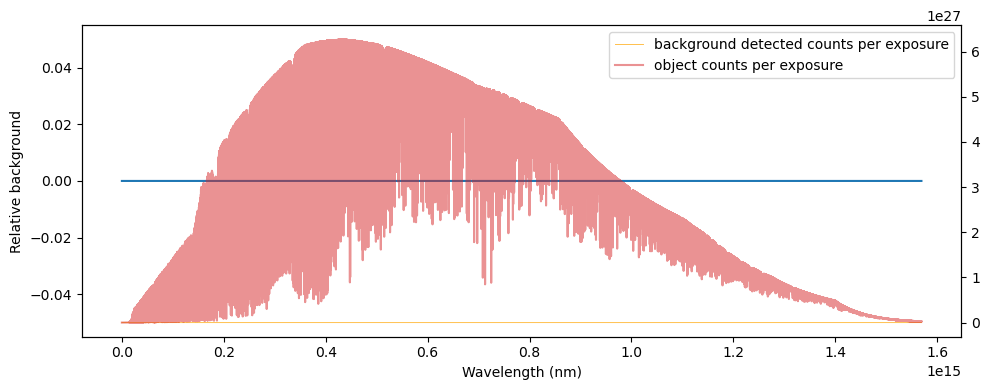

In [17]:
# Build a tunable background spectrum from lamp spectra in data/lamp_spectra/
# Loads all .txt files in data/lamp_spectra/, allows per-file magnitude scaling,
# interpolates to the notebook wavelength grid `w_q` and converts to detected counts using
# the same exposure/throughput/QE parameters used above.
import glob
from pathlib import Path
import pandas as pd
from io import StringIO

lamp_dir = Path(project_dir) / 'data' / 'lamp_spectra'
lamp_files = sorted(list(lamp_dir.glob('*.txt')))
print('Found', len(lamp_files), 'lamp spectrum files in', lamp_dir)

# Read lamp spectra: expect two columns (wavelength_nm, relative_flux) with header lines starting '#'.
lamps = []
for p in lamp_files:
    try:
        # Try to read with utf-8 first; fall back to latin-1 if needed. If both fail, decode bytes with replacement and parse via StringIO.
        try:
            df = pd.read_csv(p, comment='#', delim_whitespace=True, header=None, names=['wavelength_nm','flux_rel'], encoding='utf-8')
        except Exception:
            try:
                df = pd.read_csv(p, comment='#', delim_whitespace=True, header=None, names=['wavelength_nm','flux_rel'], encoding='latin-1')
            except Exception:
                # final fallback: read bytes and decode with replacement for invalid chars
                raw = p.read_bytes()
                txt = raw.decode('utf-8', errors='replace')
                df = pd.read_csv(StringIO(txt), comment='#', delim_whitespace=True, header=None, names=['wavelength_nm','flux_rel'])
        # coerce columns to numeric to remove header rows like 'W S' or other stray text lines
        df['wavelength_nm'] = pd.to_numeric(df['wavelength_nm'], errors='coerce')
        df['flux_rel'] = pd.to_numeric(df['flux_rel'], errors='coerce')
        df = df.dropna()
        if df.shape[0] == 0:
            print(f"File {p.name} parsed but contains no numeric rows; skipping")
            continue
        lamps.append({'path':p, 'df':df})
    except Exception as e:
        print('Failed to read', p, '->', e)

if len(lamps) == 0:
    print('No lamp spectra found; create data/lamp_spectra/ and add ascii spectra with two columns: wavelength_nm flux')

# Default per-component magnitudes (mag offsets) dictionary.
# You can edit these values in-place to tune the contribution of each lamp file.
component_mag = {str(item['path'].name): 0.0 for item in lamps}  # 0 mag = original relative scale
# Example: component_mag['HPS_High_Pressure_Sodium_2176K_Riba_Roja_cor.txt'] = -2.5  # make it 10x brighter

# Convert each lamp to a common grid (wavelength in nm) and sum after scaling by magnitude offsets.
# We'll build a background in units of relative flux per nm, then convert to photon counts by scaling to detected counts
if len(lamps) > 0:
    # target wavelength grid (use w_q from earlier cell, in nm)
    target_nm = w_q.to(u.nm).value
    combined_rel = np.zeros_like(target_nm, dtype=float)
    print(f"Target wavelength grid: {target_nm.min():.1f} - {target_nm.max():.1f} nm, {target_nm.size} bins")
    for item in lamps:
        name = str(item['path'].name)
        df = item['df']
        # ensure columns present
        if df.shape[1] < 2:
            print('Skipping', name, '- expected two columns')
            continue
        lam_nm = df['wavelength_nm'].values.astype(float)
        flux_rel = df['flux_rel'].values.astype(float)
        # sort by wavelength and remove duplicates
        order = np.argsort(lam_nm)
        lam_nm = lam_nm[order]
        flux_rel = flux_rel[order]
        # trim NaNs again defensively
        mask = np.isfinite(lam_nm) & np.isfinite(flux_rel)
        lam_nm = lam_nm[mask]
        flux_rel = flux_rel[mask]
        if lam_nm.size == 0:
            print(f"Skipping {name}: no numeric data after cleaning")
            continue
        print(f"Read {name}: {lam_nm.size} rows, range {lam_nm.min():.1f}-{lam_nm.max():.1f} nm")
        # check for overlap with target grid
        if lam_nm.max() < target_nm.min() or lam_nm.min() > target_nm.max():
            print(f"Warning: {name} wavelength range does not overlap target grid; interpolation will yield zeros")
        # apply magnitude offset: scale = 10^(-0.4 * mag)
        mag = component_mag.get(name, 0.0)
        scale = 10.0 ** (-0.4 * mag)
        interp = np.interp(target_nm, lam_nm, flux_rel, left=0.0, right=0.0) * scale
        combined_rel += interp
    # normalize combined relative shape to unit area (optional) to keep scaling predictable
    norm = np.trapz(combined_rel, target_nm)
    if norm > 0:
        combined_rel /= norm
    else:
        print('Warning: combined background has zero integrated area after summing; leaving as-is (zeros)')
else:
    target_nm = w_q.to(u.nm).value
    combined_rel = np.zeros_like(target_nm)

# Now convert combined relative background to absolute detected counts.
background_level_photons_per_s_per_nm = 1e3  # editable: photons / s / nm (reference total before throughput/QE)
reference_wavelength_nm = 550.0
# scale to wavelength-dependent photon rate per nm: photons/s/nm = background_level * combined_rel (unitless shape)
bg_photons_per_s_per_nm = combined_rel * background_level_photons_per_s_per_nm
# convert per-nm to per-bin using delta_lambda (in nm)
delta_lambda_nm = np.gradient(target_nm)
bg_photons_per_s_per_bin = bg_photons_per_s_per_nm * delta_lambda_nm
# apply instrument throughput and QE and exposure time to get detected counts per bin
bg_detected_counts_per_exposure = bg_photons_per_s_per_bin * instrument_throughput * detector_qe * exposure_s
total_bg_counts = np.sum(bg_detected_counts_per_exposure)
print(f'Background: background_level={background_level_photons_per_s_per_nm} ph/s/nm (shape normalized); total detected counts per exposure={total_bg_counts:.3g}')

# Plot background shape and detected counts alongside the object counts if available
plt.figure(figsize=(10,4))
plt.plot(target_nm, combined_rel, label='background shape (norm)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Relative background')
ax2 = plt.twinx()
ax2.plot(target_nm, bg_detected_counts_per_exposure, color='orange', alpha=0.7, lw=0.7, label='background detected counts per exposure')
# if counts_per_bin exists from earlier cell, overplot for comparison
try:
    ax2.plot(w_q.to(u.nm).value, counts_per_bin.value, color='C3', alpha=0.5, label='object counts per exposure')
except Exception:
    pass
plt.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Expose background arrays for later use
background = {
    'wavelength_nm': target_nm,
    'shape_norm': combined_rel,
    'photons_per_s_per_nm': bg_photons_per_s_per_nm,
    'photons_per_s_per_bin': bg_photons_per_s_per_bin,
    'detected_counts_per_exposure': bg_detected_counts_per_exposure,
    'total_detected_counts': total_bg_counts
}


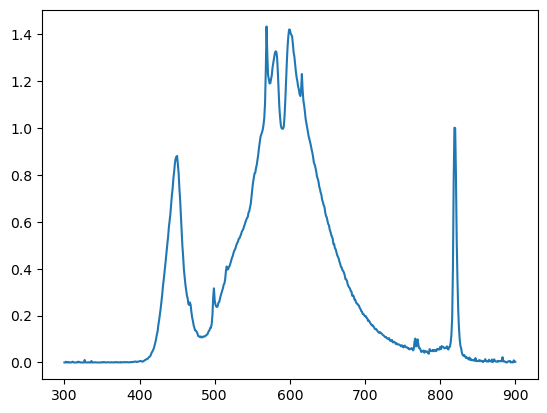

In [18]:
plt.plot(lamps[1]['df']['wavelength_nm'], lamps[0]['df']['flux_rel']+ lamps[1]['df']['flux_rel'] )